In [206]:
import numpy as np
import logging
import decimal
import math
from scipy.fftpack import dct
from scipy.signal.windows import hann
import librosa
import pandas as pd

In [207]:
# Round function
def round_half_up(number):
  return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

# Return necessary variables to correlate Greenwood scale with Hertz
def returnValueTuple():
  fmin = 14
  fmax = 12000
  k = 0.88
  A = fmin/(1-k)
  a = math.log10(fmax/A+k)
  return (a,A,k)

# Retreive Greenwood from Hertz
def greenwood_from_hertz(hertz):
  a,A,k = returnValueTuple()
  f = hertz
  return (1/a)*math.log10(f/A+k)

# Retreive Hertz from Greenwood
def hertz_from_greenwood(greenwood):
  a,A,k = returnValueTuple()
  fp = greenwood
  return A*(10**(a*fp)-k)

In [208]:
# NFFT: The size of FFT, It FFT number is less the precision will be less because of dropping many samples; 
#       Using large FFT allows zero padding which is neutral when frequency domain is concerened
#       Here Multiplication by 2 is done which allows some padding but is safe as no sample are dropped 
def calculateNFFTS(sampleRate,windowLength):
  windowLengthSample = windowLength*sampleRate
  nfft = 1
  while nfft < windowLengthSample:
    nfft*=2
  return nfft

# Pre Emphasis: Amplification of high frequencies to balance the frequency spectrum as high frequencies tend to have low magnitude when compared to lower ones
# Formula: x`(n) = x(n) - a*x(n-1) where a = pre-emphasis factor
def preEmphasis(signal,preEmphasisFactor=0.97):
  return np.append(signal[0], signal[1:] - preEmphasisFactor * signal[:-1])

# Numpy stride technique, refer: 
# https://ellisvalentiner.com/post/np-strides-trick/ and
# https://ipython-books.github.io/46-using-stride-tricks-with-numpy/
def rollingWindow(paddedSignal,frameLength,step=1):
    shape = paddedSignal.shape[:-1] + (paddedSignal.shape[-1] - frameLength + 1, frameLength)
    strides = paddedSignal.strides + (paddedSignal.strides[-1],)
    return np.lib.stride_tricks.as_strided(paddedSignal, shape=shape, strides=strides)[::step]

# Cut the signal in frames, frameStep = Number of frames of previous sample after which 2nd sample frames should start, strideTrick uses internal numpy method
def frameSignal(signal, frameLength, frameStep, windowFunction):

  lengthOfSignal = len(signal)
  frameLength = int(round_half_up(frameLength))
  frameStep = int(round_half_up(frameStep))

  if lengthOfSignal < frameLength:
    numberOfFrames = 1
  else:
    numberOfFrames = 1 + int(math.ceil((1.0 * lengthOfSignal - frameLength) / frameStep))

  paddingLength = int((numberOfFrames - 1) * frameStep + frameLength)
  zeros = np.zeros((paddingLength - lengthOfSignal,))
  paddedsignal = np.concatenate((signal, zeros))

  # Use numpy to efficiently make windows
  window = windowFunction(frameLength)
  frames = rollingWindow(paddedsignal,frameLength,step = frameStep)

  return frames * window

# Magnitude Spectrum: Calculated using numpy.fft.rfft' returns the absolute values after taking fourier transfrom
def magSpectrum(frames,nfft):
  if np.shape(frames)[1] > nfft:
    logging.warn('frame length {} is greater than FFT size {}, frame will be truncated. Increase NFFT to avoid.'.format(np.shape(frames)[1],nfft))
  complexSpectrum = np.fft.rfft(frames,nfft)
  return np.absolute(complexSpectrum)

# Power Spectrum: Calulated using 1/n*|si|^2 where 'si' is fourier transform
def powSpectrum(frames,nfft):
  return 1.0/nfft*np.square(magSpectrum(frames,nfft))

# Log power spectrum and normalize: Not needed
def logPowSpectrum(frames,nfft,normalize = 1):
  powerSpectrum = powSpectrum(frames,nfft)
  # If values are close to 0 or 0 log function will have problem
  powerSpectrum[powerSpectrum<= 1e-30] = 1e-30
  logPowerSpectrum = 10*np.log10(powerSpectrum)
  if normalize:
    return logPowerSpectrum - np.max(logPowerSpectrum)
  else:
    return logPowerSpectrum

# Returns Filter Banks: 
# Filters correspond to rows and Columns correspond to fft bins
# returns: array of size = numberOfFilter*(nfft/2+1)
def returnFilterBanks(numberOfFilter=30,nfft=512,sampleRate=16000,lowFrequency=0,highFrequency=None):
  highFrequency= highFrequency or sampleRate/2
  assert highFrequency <= sampleRate/2, "High Frequency is greater than sampleRate/2"

  # Calculate evenly spaced pts in greenwood
  lowGreenWood = greenwood_from_hertz(lowFrequency)
  highGreenWood = greenwood_from_hertz(highFrequency)
  greenWoodPoints = np.linspace(lowGreenWood,highGreenWood,numberOfFilter+2)

  # Current points are in Hertz, but we use fft bins, so we have to convert from Hertz to fft bin number
  bin = np.floor((nfft+1)*hertz_from_greenwood(greenWoodPoints)/sampleRate)

  fbank = np.zeros([numberOfFilter,nfft//2+1])
  for j in range(0,numberOfFilter):
      for i in range(int(bin[j]), int(bin[j+1])):
          fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
      for i in range(int(bin[j+1]), int(bin[j+2])):
          fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
  return fbank

# Array of banpass filters(filters which decide what frequencies can pass)
def filterBank(signal,sampleRate=16000, windowLength=0.025, windowStep=0.01, numberOfFilter=30, nfft=512,
               lowFrequency=0, highFrequency=None, preEmphasisFactor=0.97, windowFunction=lambda x: np.ones((x,))):
  
  highFrequency = highFrequency or sampleRate/2
  
  # Step 1: Apply pre emphasis on signal
  signal = preEmphasis(signal,preEmphasisFactor)

  # Step 2: Frame a signal to overlapping signals: 2d nd array
  frames = frameSignal(signal, windowLength*sampleRate, windowStep*sampleRate, windowFunction)

  # Step 3: Calculate the power spectrum
  powerSpec = powSpectrum(frames,nfft)
  
  # Step 4: Calculate the total energy in each frame
  energy = np.sum(powerSpec,1)
  energy = np.where(energy==0,np.finfo(float).eps,energy)

  # Step 5: Get Filter Banks and its energy
  filterBank = returnFilterBanks(numberOfFilter,nfft,sampleRate,lowFrequency,highFrequency)
  features = np.dot(powerSpec,filterBank.T)
  features = np.where(features==0,np.finfo(float).eps,features)

  return features,energy

# Apply Sinosoidal liftering: Increases the magnitude of highFrequency DCT coefficients
# To de-emphasize higher MFCCs which has been claimed to improve audio detection under noisy circumstances 
def lifter(cepstra,lifterParameter=22):
  L = lifterParameter
  if L > 0:
    nframes,ncoeff = np.shape(cepstra)
    n = np.arange(ncoeff)
    lift = 1 + (L/2.)*np.sin(np.pi*n/L)
    return lift*cepstra
  else:
    return cepstra # No liftering

In [209]:
def gfcc(signal,sampleRate = 16000, windowLength = 0.025, windowStep = 0.01, returnCepstrumNumber = 13, 
         numberOfFilter = 30, nfft = None, lowFrequency = 0, highFrequency = None, preEmphasisFactor = 0.97, 
         lifterParameter = 22, appendEnergy = True, windowFunction = lambda x: np.ones((x,))):
  
  # Step 1: Calculate the length of analysis window
  nfft = nfft or calculateNFFTS(sampleRate,windowLength)

  # Step 2 + 3: Calculate Greenwood Filter Bank and apply to power spectrum
  features, energy = filterBank(signal,sampleRate, windowLength,windowStep, numberOfFilter, nfft, lowFrequency, highFrequency, preEmphasisFactor, windowFunction)

  # Step 4: Take log of features
  features = np.log(features)

  # Step 5: Take discrete fourier transform
  features = dct(features,axis=1,norm='ortho')[:,:returnCepstrumNumber]

  # Step 6: Liftering
  features = lifter(features,lifterParameter)

  # First frame generally defines energy of that frame
  if appendEnergy:
    features[:,0] = np.log(energy)
  
  return features

In [210]:
def feature_extractor(file):
  audio,sample_rate = librosa.load(file,res_type='kaiser_fast')
  gfccs = gfcc(audio,sample_rate,windowFunction=hann,returnCepstrumNumber=18,preEmphasisFactor=0,lifterParameter=0)
  gfcc_scaled_features = np.mean(gfccs,axis=0)
  return gfcc_scaled_features

In [211]:
training_data_path = '../mubin/Data/Training'
testing_data_path = '../mubin/Data/Testing'

In [212]:
# Remove unwanted files

for path in [testing_data_path,training_data_path]:
    for folder in ['Noise','Rumbles']:
        for file in ['.amlignore', '.amlignore.amltmp']:
            if os.path.exists(path+'/'+folder+'/'+file):
                os.remove(path+'/'+folder+'/'+file)
    

## Train and Validation Set

In [213]:
noiseFiles = next(os.walk(training_data_path+'/Noise'))[2]
print(len(noiseFiles))

rumbleFiles = next(os.walk(training_data_path+'/Rumbles'))[2]
print(len(rumbleFiles))

print(len(noiseFiles)==len(rumbleFiles))

3180
3180
True


In [214]:
noise_set_size = len(noiseFiles)
rumble_set_size = len(rumbleFiles)

noiseList = [['Noise/noise_'+str(i)+'.wav','noise'] for i in range(1,noise_set_size+1)]
rumbleList = [['Rumbles/rumble_'+str(i)+'.wav','rumble'] for i in range(1,rumble_set_size+1)]
finalList = noiseList+rumbleList

train_df = pd.DataFrame(finalList, columns =['Filename', 'Class'])

In [215]:
train_df

,Filename,Class
0,Noise/noise_1.wav,noise
1,Noise/noise_2.wav,noise
2,Noise/noise_3.wav,noise
3,Noise/noise_4.wav,noise
4,Noise/noise_5.wav,noise
...,...,...
6355,Rumbles/rumble_3176.wav,rumble
6356,Rumbles/rumble_3177.wav,rumble
6357,Rumbles/rumble_3178.wav,rumble
6358,Rumbles/rumble_3179.wav,rumble


In [216]:
def features_extractor(file):
  audio,sample_rate = librosa.load(file,res_type='kaiser_fast')
  gfccs = gfcc(audio,sample_rate,windowFunction=hann,returnCepstrumNumber=18,lowFrequency=10)
  gfcc_scaled_features = np.mean(gfccs,axis=0)
  return gfcc_scaled_features

In [217]:
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(train_df.iterrows()):
    file_name = training_data_path+'/'+row['Filename']
    class_name = row['Class']
    data = features_extractor(file_name)
    extracted_features.append([data,class_name])

6360it [09:45, 10.86it/s]


In [218]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-2.7742346467415677, 11.197860893261826, -71....",noise
1,"[-2.686257586667402, 11.160884023039879, -72.1...",noise
2,"[-2.719486179571193, 10.724759885589451, -71.4...",noise
3,"[-2.7067643900422573, 11.015782689283833, -72....",noise
4,"[-2.6791133929473694, 11.318273084983144, -72....",noise


In [219]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [220]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

In [221]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
y_train = to_categorical(labelencoder.fit_transform(y_train))

In [222]:
print(X_train.shape,y_train.shape)

(5088, 18) (5088, 2)


In [223]:
y_val = to_categorical(labelencoder.transform(y_val))

In [224]:
print(X_val.shape,y_val.shape)

(1272, 18) (1272, 2)


## Test Set

In [225]:
noiseTestFiles = next(os.walk(testing_data_path+'/Noise'))[2]
print(len(noiseTestFiles))

rumbleTestFiles = next(os.walk(testing_data_path+'/Rumbles'))[2]
print(len(rumbleTestFiles))

print(len(noiseTestFiles)==len(rumbleTestFiles))

noise_test_set_size = len(noiseTestFiles)
rumble_test_set_size = len(rumbleTestFiles)

noiseTestList = [['Noise/noise_'+str(i)+'.wav','noise'] for i in range(1,noise_test_set_size+1)]
rumbleTestList = [['Rumbles/rumble_'+str(i)+'.wav','rumble'] for i in range(1,rumble_test_set_size+1)]
finalTestList = noiseTestList+rumbleTestList

test_df = pd.DataFrame(finalTestList, columns =['Filename', 'Class'])

757
757
True


In [226]:
test_df

,Filename,Class
0,Noise/noise_1.wav,noise
1,Noise/noise_2.wav,noise
2,Noise/noise_3.wav,noise
3,Noise/noise_4.wav,noise
4,Noise/noise_5.wav,noise
...,...,...
1509,Rumbles/rumble_753.wav,rumble
1510,Rumbles/rumble_754.wav,rumble
1511,Rumbles/rumble_755.wav,rumble
1512,Rumbles/rumble_756.wav,rumble


In [227]:
extracted_test_features=[]
for index_num,row in tqdm(test_df.iterrows()):
    file_name = testing_data_path+'/'+row['Filename']
    class_name = row['Class']
    data = features_extractor(file_name)
    extracted_test_features.append([data,class_name])

1514it [02:18, 10.89it/s]


In [228]:
extracted_test_features_df=pd.DataFrame(extracted_test_features,columns=['feature','class'])
extracted_test_features_df.head()

,feature,class
0,"[-3.0797442981364695, 11.338257063850921, -73....",noise
1,"[-3.075741105588124, 11.108618808954224, -73.1...",noise
2,"[-3.0830289176104855, 11.181089276987564, -73....",noise
3,"[-2.938467449148092, 22.563418787639403, -79.6...",noise
4,"[-2.982341041721689, 22.745090798299028, -79.7...",noise


In [229]:
X_test=np.array(extracted_test_features_df['feature'].tolist())
y_test=np.array(extracted_test_features_df['class'].tolist())

In [230]:
y_test = to_categorical(labelencoder.transform(y_test))

In [231]:
print(X_test.shape,y_test.shape)

(1514, 18) (1514, 2)


In [232]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [233]:
num_labels = 2
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(18,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(2))
model.add(Activation('softmax'))

In [234]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               1900      
_________________________________________________________________
activation_20 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_21 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)              

In [235]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [236]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

In [237]:
num_epochs = 400
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/rumble_classification.hdf5', verbose=1, save_best_only=True)

earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer,earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 5088 samples, validate on 1272 samples
Epoch 1/400
4992/5088 [============================>.] - ETA: 0s - loss: 4.0454 - accuracy: 0.5621
Epoch 00001: val_loss improved from inf to 0.60065, saving model to saved_models/rumble_classification.hdf5
5088/5088 [==============================] - 1s 208us/sample - loss: 3.9989 - accuracy: 0.5621 - val_loss: 0.6007 - val_accuracy: 0.6997
Epoch 2/400
4288/5088 [========================>.....] - ETA: 0s - loss: 0.9518 - accuracy: 0.6005
Epoch 00002: val_loss did not improve from 0.60065
5088/5088 [==============================] - 0s 71us/sample - loss: 0.9209 - accuracy: 0.6012 - val_loss: 0.6093 - val_accuracy: 0.7248
Epoch 3/400
4480/5088 [=========================>....] - ETA: 0s - loss: 0.6488 - accuracy: 0.6674
Epoch 00003: val_loss improved from 0.60065 to 0.59154, saving model to saved_models/rumble_classification.hdf5
5088/5088 [==============================] - 0s 97us/sample - loss: 0.6491 - accuracy: 0.6688 - val_loss: 0.591

In [238]:
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7212682


In [255]:
y_preds = model.predict(X_test)

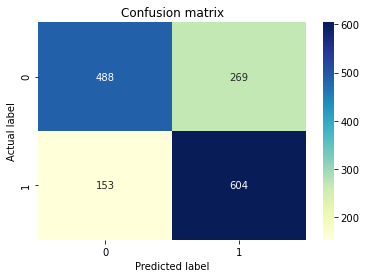

In [260]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cnf_matrix = metrics.confusion_matrix(np.argmax(y_test,axis=-1), np.argmax(y_preds,axis=-1))
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Downsample
